# Realtion between unemployment rates and safety needs

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from helpers import *
import plotly.express as px
from datetime import datetime
import statsmodels.formula.api as smf
import re


In [11]:
#import data
dfeu = pd.read_csv('DATA/eu.tsv',sep='\t')
countries = pd.read_csv('DATA/countries_list.csv.xls')


In [12]:
dfts=process_eu_unemployment(dfeu,countries)

In [114]:
dfts=dfts[~(dfts['Country'].isin(['United States','Japan','Turkey']))]
dfts

,Country,age,unit,sex,Country_code,Date,Value,Year,Month
0,Austria,TOTAL,PC_ACT,F,AT,2020-07-01,4.5,2020,7
1,Austria,TOTAL,PC_ACT,M,AT,2020-07-01,5.8,2020,7
2,Austria,TOTAL,PC_ACT,T,AT,2020-07-01,5.2,2020,7
3,Austria,TOTAL,THS_PER,F,AT,2020-07-01,96.0,2020,7
4,Austria,TOTAL,THS_PER,M,AT,2020-07-01,142.0,2020,7
...,...,...,...,...,...,...,...,...,...
18230,United Kingdom,Y_LT25,PC_ACT,M,UK,2018-01-01,12.7,2018,1
18231,United Kingdom,Y_LT25,PC_ACT,T,UK,2018-01-01,11.9,2018,1
18232,United Kingdom,Y_LT25,THS_PER,F,UK,2018-01-01,228.0,2018,1
18233,United Kingdom,Y_LT25,THS_PER,M,UK,2018-01-01,279.0,2018,1


In [124]:
len(dfts['Country'].unique()[:-3])

28

## General look over all EU data

The following methods helps us to put everything in perspective by plotting the evolution of the percentages of unemployed people

In [205]:
def process_group_df(df,test_group):
    df=df.reset_index().copy()
    df[test_group]=df[test_group].astype('category')
    df['lockdown']=np.where(df['Date']>=datetime(2020,3,1),1,0)
    return df

## General pipeline for processing the aforementionned data
def unemployment_across_groups(dfts,test_group,size=(12,18)):
    #devide dataset between different metrics
    df_percentage=dfts[dfts['unit']=='PC_ACT'].drop(columns='unit').copy()
    df_numeric=dfts[~(dfts['unit']=='PC_ACT')].drop(columns='unit').copy()
    #compile data needed for graph generation
    generals=[df_percentage,df_numeric]
    ylabels=['Unemployment Percentage','Unemployed People (x1000)']
    #Generate plot with two pannels 
    fig,axs=plt.subplots(2,1,figsize=size,sharex=True)
    #Iterate over each metric dataset
    results=[]
    for i in range(len(generals)):
        #Select metric
        df=generals[i]
        #Aggregate by testing group and Date to get monthly mean 
        df_agg=df.groupby([test_group,'Date']).mean(numeric_only=True)['Value'].copy()
        #'Flatten' the indeces to get only one index column corresponding to the testing group
        df_agg=df_agg.reset_index(level='Date')
        #Plot the different lines for each of the testing group elements
        for idx in df_agg.index.unique(): 
            axs[i].plot(df_agg.loc[idx]['Date'],df_agg.loc[idx]['Value'],label=idx)
        #Add details to the plot
        axs[i].axvline(x=datetime(2020,3,1),color='red', linestyle='--', label='Lockdown')
        axs[i].legend(loc='upper left')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel(ylabels[i])
        axs[i].set_title(f'{ylabels[i]} per {test_group} across Europe')
        df_agg=process_group_df(df_agg,test_group)
        results.append(df_agg)
    plt.show()
    return results

def regression_helper(data_array,group):
    result_array=[]
    for df in data_array:
        model=smf.ols(data=df,formula=f'Value~{group}:lockdown')
        res=model.fit()
        result_array.append(res)
    return result_array

### Distribution amongst age groups

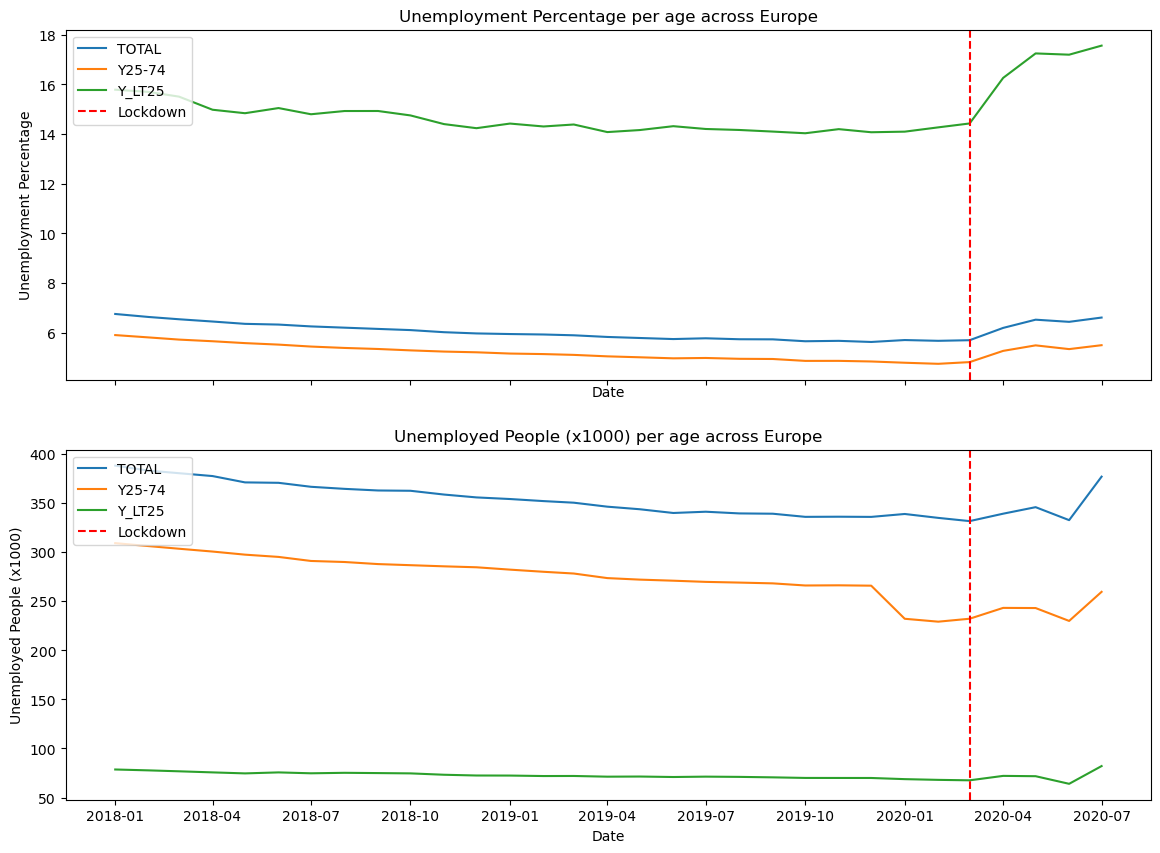

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     8.280
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           6.43e-05
Time:                        13:54:53   Log-Likelihood:                -258.65
No. Observations:                  93   AIC:                             525.3
Df Residuals:                      89   BIC:                             535.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.5991 

In [209]:
res_age=unemployment_across_groups(dfts,'age',(14,10))
regression_age=regression_helper(res_age,'age')
for r in regression_age:
    print(r.summary())

### Distribution amongst sexes

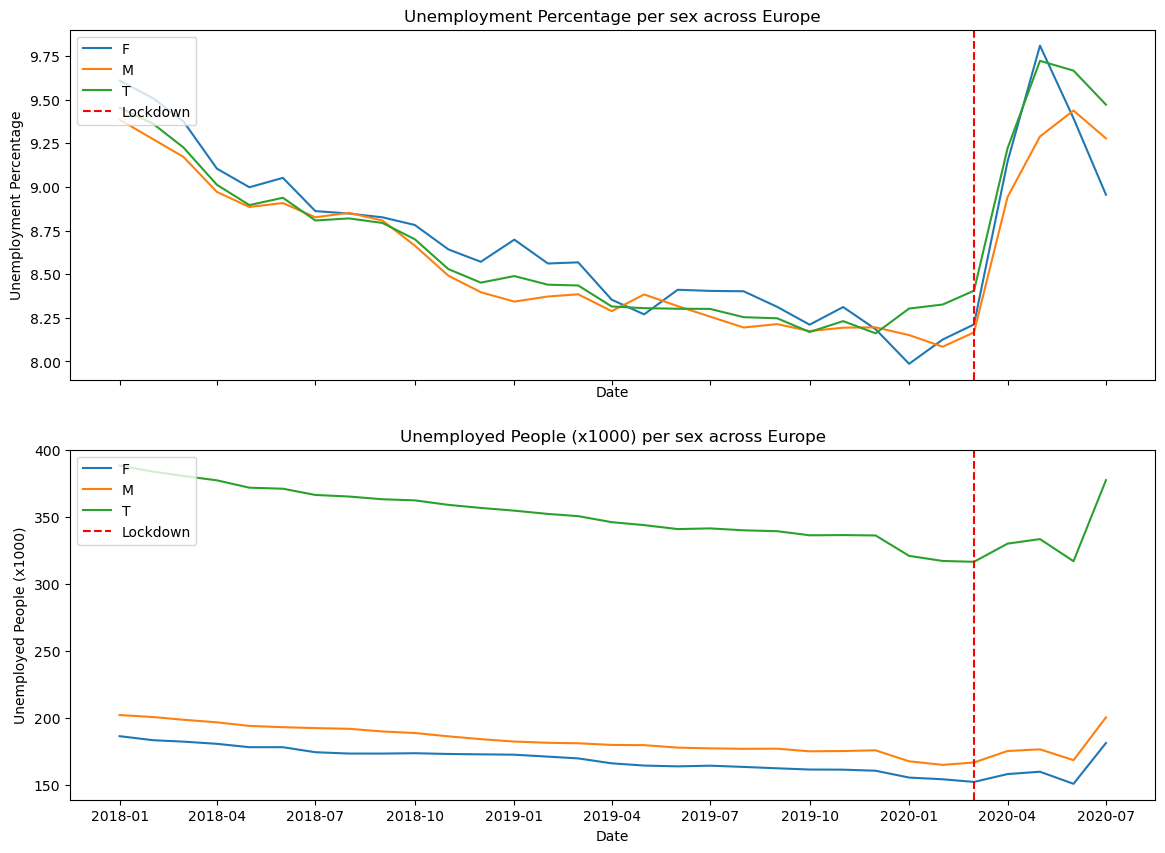

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     7.527
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           0.000152
Time:                        13:55:30   Log-Likelihood:                -48.773
No. Observations:                  93   AIC:                             105.5
Df Residuals:                      89   BIC:                             115.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.5952      0.047    1

In [210]:
res_sex=unemployment_across_groups(dfts,'sex',(14,10))
regression_sex=regression_helper(res_sex,'sex')
for r in regression_sex:
    print(r.summary())

## Distribution amongst Countries

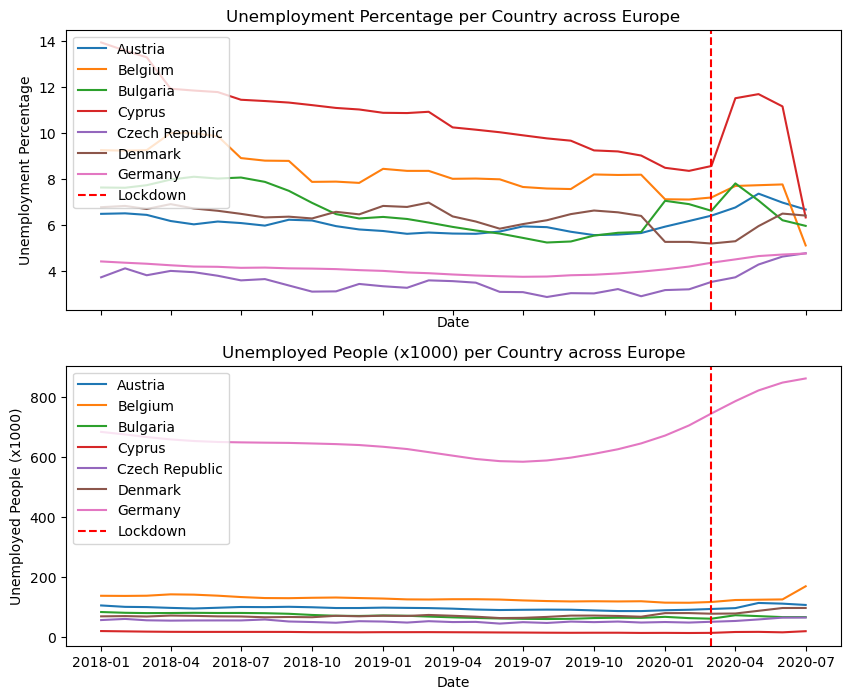

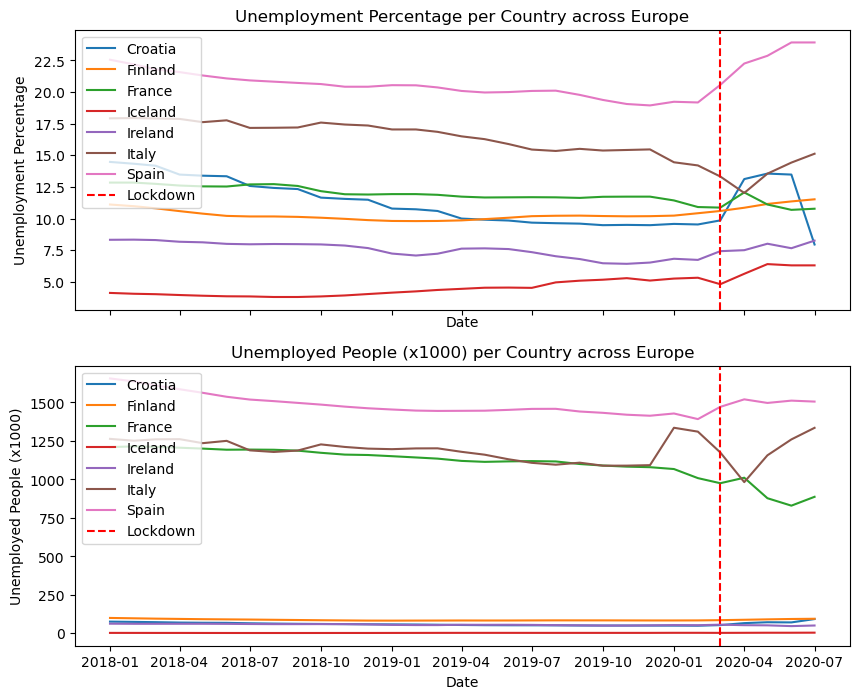

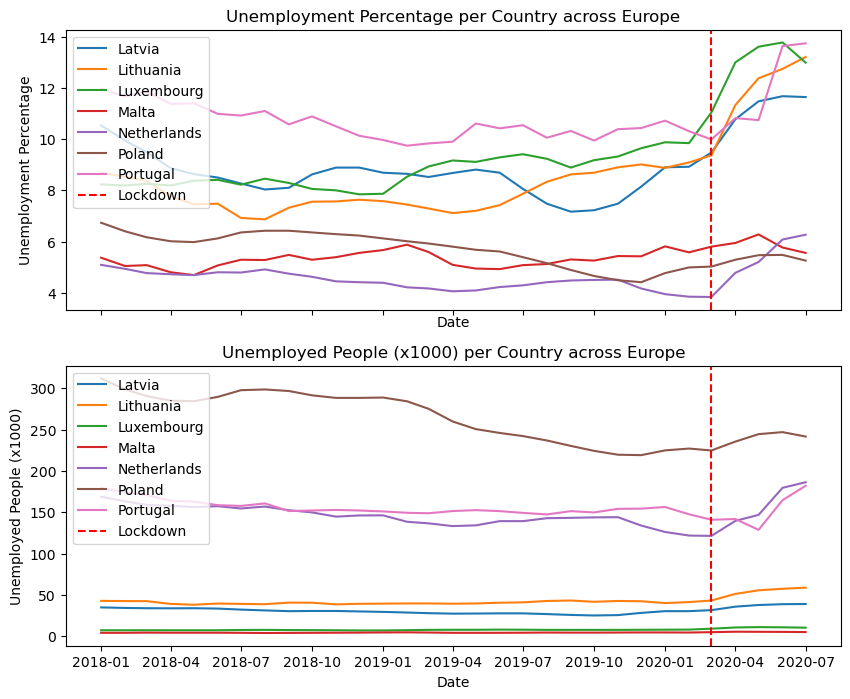

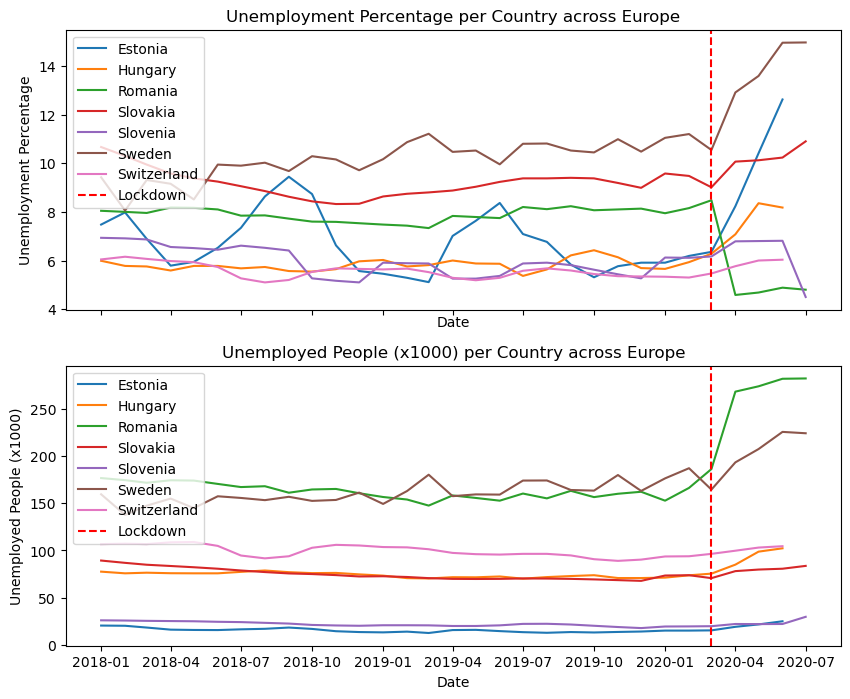

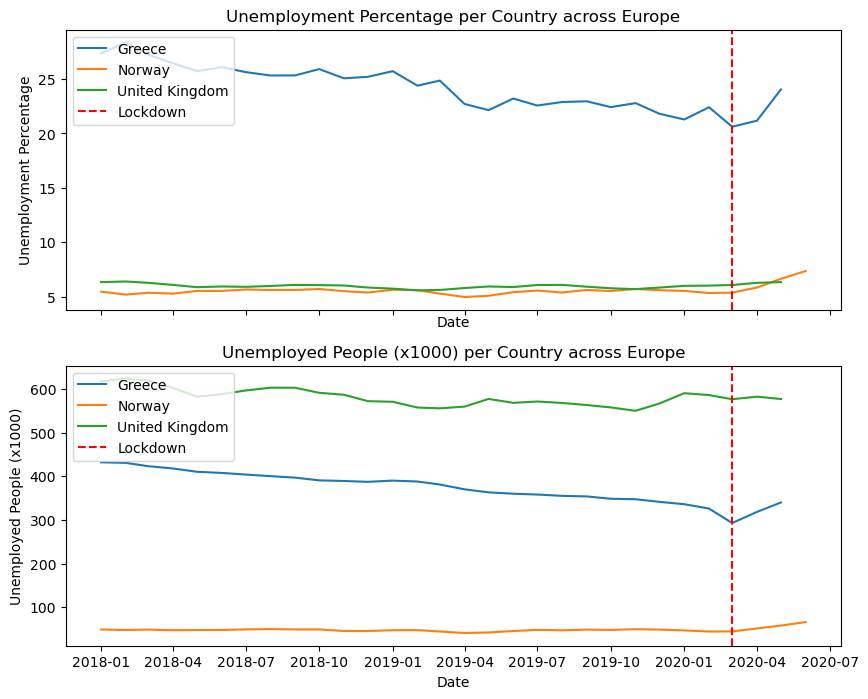

In [199]:
splits=np.split((dfts['Country'].unique())[:-3],4)
splits.append(dfts['Country'].unique()[-3:])
dfs_country=[dfts[dfts['Country'].isin(s)] for s in splits]
res_country=[]
for df_country in dfs_country:
    r_group=unemployment_across_groups(df_country,'Country',size=(10,8))
    res_country.append(r_group)

In [212]:
for r in res_country:
    for result in regression_helper(r,'Country'):
        print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.801
Date:                Thu, 07 Dec 2023   Prob (F-statistic):            0.00830
Time:                        13:58:56   Log-Likelihood:                -486.33
No. Observations:                 217   AIC:                             988.7
Df Residuals:                     209   BIC:                             1016.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## TO DO
- ask nico wag1 with the units
- look into a treatment and control centric approach to this case study
- regress